In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
from sqlalchemy import inspect, distinct

In [5]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
last_day_inDataSet = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_day_inDataSet)

('2017-08-23',)


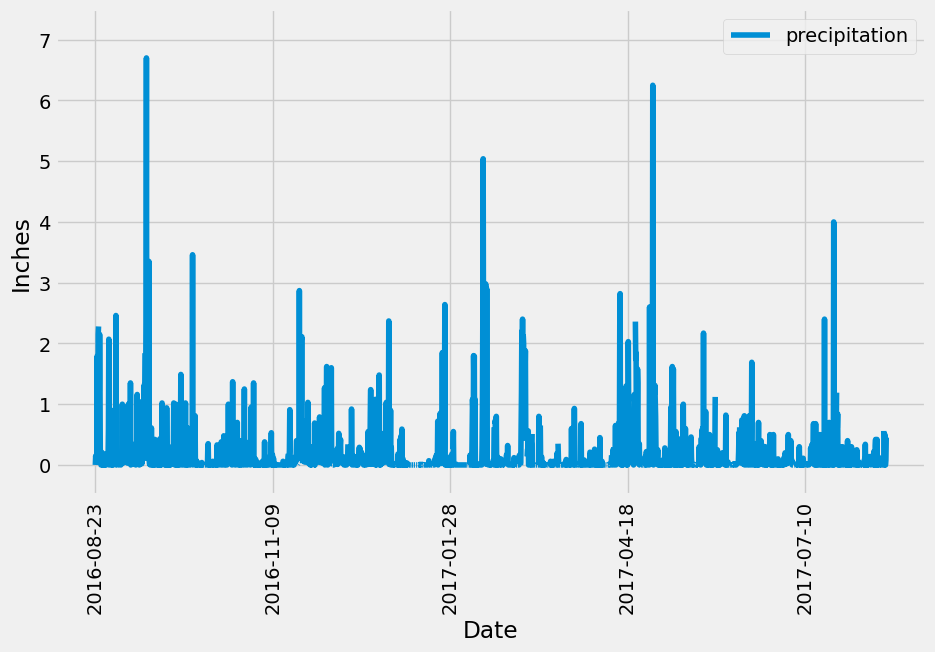

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_day = dt.date(2017, 8, 23)
one_year_back = last_day - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_back).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(xlabel='Date',ylabel='Inches',rot=90,figsize=(10,6))
plt.ylim(-0.5,7.5)
# plt.savefig('Images/precipitation.svg')
plt.show()


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(func.count(distinct(Station.station))).scalar()
stations

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = 'USC00519281'
lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_id).scalar()
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_id).scalar()
avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_id).scalar()
print(f'Lowest: {lowest}℉')
print(f'Highest: {highest}℉')
print(f'Average: {round(avg, 1)}℉')

Lowest: 54.0℉
Highest: 85.0℉
Average: 71.7℉


Text(0, 0.5, 'Frequency')

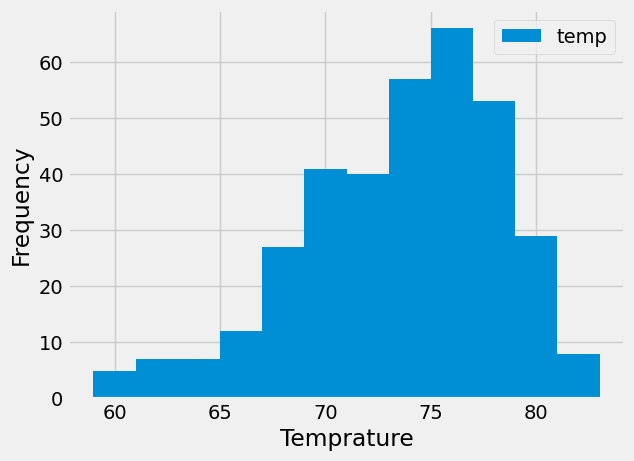

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_year_temps = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= one_year_back).order_by(Measurement.station).all()

station_year_df = pd.DataFrame(station_year_temps, columns=['station', 'temp'])

active_df = station_year_df.loc[station_year_df['station'] == station_id]

active_df.plot(kind='hist', column='temp', bins=12)
plt.xlabel('Temprature')
plt.ylabel('Frequency')

# Close session

In [21]:
# Close Session
session.close()